## XGBoost - Predicting Home Prices using SageMaker's High Level Python API

* Project: To predict the median value of a home in the area of Boston Mass using XGBoost Model, in SageMaker, using High Level Python API
* Dataset:[Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) 
* Documentation: [High level API documentation](http://sagemaker.readthedocs.io/en/latest/)
* Author: Shashi Kiran Chilukuri

### Steps followed to create, train, test, deploy model
1. Importing Python libraries, modules & sagemaker objects
2. Download or otherwise retrieve the data.
3. Process / Prepare the data.
4. Upload the processed data to S3.
5. Train a chosen model.
6. Test the trained model (typically using a batch transform job).
7. Deploy the trained model.
8. Use the deployed model.

## Step 1: Importing Python libraries, modules & sagemaker objects

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

%matplotlib inline

# Importing Sagemaker objects
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# Session gives currently operating session details
session = sagemaker.Session()

# role gives 'IAM role' that we are currently assigned. This will be useful constructing
# and launching the training job
role = get_execution_role()

## Step 2: Downloading the data
Bosting Housing dataset can be retrieved using sklearn

In [3]:
boston = load_boston()

## Step 3: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets. 

Note: XGBoost is prone to overfitting, to avoid that we are validation data

In [4]:
# Creating the dataframes for inputs and targets 
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# Splitting dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Splitting training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 4: Uploading the data files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details.

**Save the data locally:** First we need to create the test, train and validation csv files which we will then upload to S3.

In [6]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [7]:
# Saving as test, train, validation csv files
# Note that we make sure not to include header information or an index 

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

**Upload to S3:** Upload our data to the 'default' S3 bucket and addinga custom prefix

In [8]:
prefix = 'boston-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 5: Train the XGBoost model

To Train the model, we need to construct an estimator (for high level api). For that we need to
- Provide the location of a container which contains the training code(since we are using a built in algorithm this container is provided by Amazon). We will be using SageMaker utility method called `get_image_uri` to constructs the image name for us.
 > To use the `get_image_uri` method we need to provide it with our current region, which can be obtained from the session object, and the name of the algorithm we wish to use.  The list of built in algorithms can be found in the [list](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).
- The IAM role to use (our current role in this case)
- The number of instances to use for training
- The type of instance to use for training
- Where to save the output (the model artifacts)
- The current SageMaker session

In [9]:
# Using `get_image_uri` utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Constructing the estimator object.
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

**Seting model specific hyperparameters:** For additional information on [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [10]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

**Training the model** using `fit` method by providing the Train and validation data location

In [11]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2019-01-24-17-18-59-589


2019-01-24 17:18:59 Starting - Starting the training job...
2019-01-24 17:19:02 Starting - Launching requested ML instances......
2019-01-24 17:20:00 Starting - Preparing the instances for training...
2019-01-24 17:21:00 Downloading - Downloading input data
2019-01-24 17:21:00 Training - Downloading the training image...
2019-01-24 17:21:24 Uploading - Uploading generated training model
Arguments: train
[2019-01-24:17:21:23:INFO] Running standalone xgboost training.
[2019-01-24:17:21:23:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8451.68mb
[2019-01-24:17:21:23:INFO] Determined delimiter of CSV input is ','
[17:21:23] S3DistributionType set as FullyReplicated
[17:21:23] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-01-24:17:21:23:INFO] Determined delimiter of CSV input is ','
[17:21:23] S3DistributionType set as FullyReplicated
[17:21:23] 112x13 matrix with 1456 entries lo

## Step 6: Test the model

To test our trained model, we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fit model.

In [12]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-01-24-17-18-59-589


Now we will use batch transform job using our trained model. For that we need to provide
- Location of the test data we previously stored in S3. 
- Type of data that we are providing to our model, in our case `text/csv`
- How to split our data up into chunks if the entire data set happens to be too large to send to our model all at once.

In [13]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

INFO:sagemaker:Creating transform job with name: xgboost-2019-01-24-17-31-23-733


Note that when we ask SageMaker to do this it will execute the batch transform job in the background. Since we need to wait for the results of this job before we can continue, we use the `wait()` method. An added benefit of this is that we get some output from our batch transform job which lets us know if anything went wrong.

In [14]:
xgb_transformer.wait()

......................................!


**Analysing the Test results:** Test results will be stored on S3. To analyze the output inside of our notebook we need to copy the output file from its S3 location and save it locally.

In [16]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-637354651523/xgboost-2019-01-24-17-31-23-733/test.csv.out to ../data/boston/test.csv.out


In [17]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5,1,'Median Price vs Predicted Price')

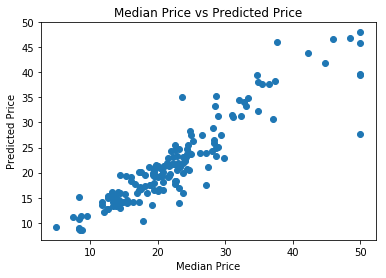

In [18]:
# Scatter plot between the predicted and actual values
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Step 7: Deploy the trained model

Deploying is very simple when we use the high level API, we need only call the `deploy` method of our trained estimator.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until **you** shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for. In other words **If you are no longer using a deployed endpoint, shut it down!**

In [19]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-01-24-17-49-01-568
INFO:sagemaker:Creating endpoint with name xgboost-2019-01-24-17-18-59-589


--------------------------------------------------------------!

## Step 8: Use the model
We can evaluate the results here 

In [20]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Y_eval = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up as a numpy array
Y_eval = np.fromstring(Y_eval, sep=',')

Text(0.5,1,'Median Price vs Evaluated Price')

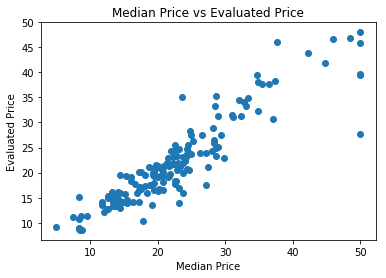

In [23]:
# Scatter plot between the evaluated and actual values
plt.scatter(Y_test, Y_eval)
plt.xlabel("Median Price")
plt.ylabel("Evaluated Price")
plt.title("Median Price vs Evaluated Price")

## Delete the endpoint and clean up the disk space

Since we are no longer using the deployed model we need to make sure to shut it down. Remember that you have to pay for the length of time that your endpoint is deployed so the longer it is left running, the more it costs

In [24]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-01-24-17-18-59-589


### Cleaning up up disk space

In [25]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir